# Data

In [26]:
import pandas as pd
import numpy as np
import random

def modificar_dataframe(df, pct_filas = 0.1, pct_cambio = 0.2):
    # Número de filas y columnas del DataFrame
    num_filas = len(df)
    num_columnas = len(df.columns[:-1])
    
    # Seleccionar aleatoriamente el 10% de las filas
    num_filas_modificar = int(num_filas * pct_filas)
    filas_modificar = np.random.choice(df.index, size=num_filas_modificar, replace=False)
    
    # Seleccionar aleatoriamente un número de columnas (entre 1 y el número total de columnas)
    num_columnas_modificar = np.random.randint(1, num_columnas + 1)
    columnas_modificar = np.random.choice(df.columns[:-1], size=num_columnas_modificar, replace=False)
    columnas_modificar = ['Speed (cm/s)']

    # Modificar los valores de las filas y columnas seleccionadas en un 15%
    for fila in filas_modificar:
        for columna in columnas_modificar:
            df.at[fila, columna] = int(df.at[fila, columna] * (1 + pct_cambio * random.uniform(1, 1.5)))
            df.at[fila, 'label'] = 1

    df.to_csv('tmp.csv')
            
    return df

def vicomtech_data(pct_cambio, pct_filas = 0.05):
    dataframe = pd.read_csv('/home/nics/Repos/5G-Tactile-IDS/data/RecFile_1_20240712_095926_CAM_Generator_output_list.csv')
    dataframe['label'] = 0
    # dataframe = dataframe.drop('Timestamp (UNIX) ', axis=1)
    dataframe = dataframe.drop('Unnamed: 0', axis=1)

    modificar_dataframe(dataframe, pct_filas=pct_filas, pct_cambio=pct_cambio)

    return dataframe

df = vicomtech_data(pct_cambio = .3, pct_filas = 0.03)
df = df.iloc[0:100]
df.head(5)

,Timestamp (UNIX),Generation Delta Time,Latitude,Longitude,Altitude,Heading Value,Speed (cm/s),Longitudinal acceleration,Curvature value,label
0,1.720771e+09,27308,431910006,-24485908,15872,726,815,0,309,0
1,1.720771e+09,27408,431910029,-24485812,15877,732,813,-2,333,0
2,1.720771e+09,27508,431910052,-24485717,15882,737,812,0,102,0
3,1.720771e+09,27608,431910074,-24485621,15887,743,812,0,266,0
4,1.720771e+09,27708,431910095,-24485525,15891,749,811,0,585,0


# Scoring

In [27]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

def evaluate(Y, Y_pred):

    roc_auc = roc_auc_score(Y, Y_pred)
    print(f'ROC: {roc_auc}')

    # Compute confusion matrix
    cm = confusion_matrix(Y, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

# IForest

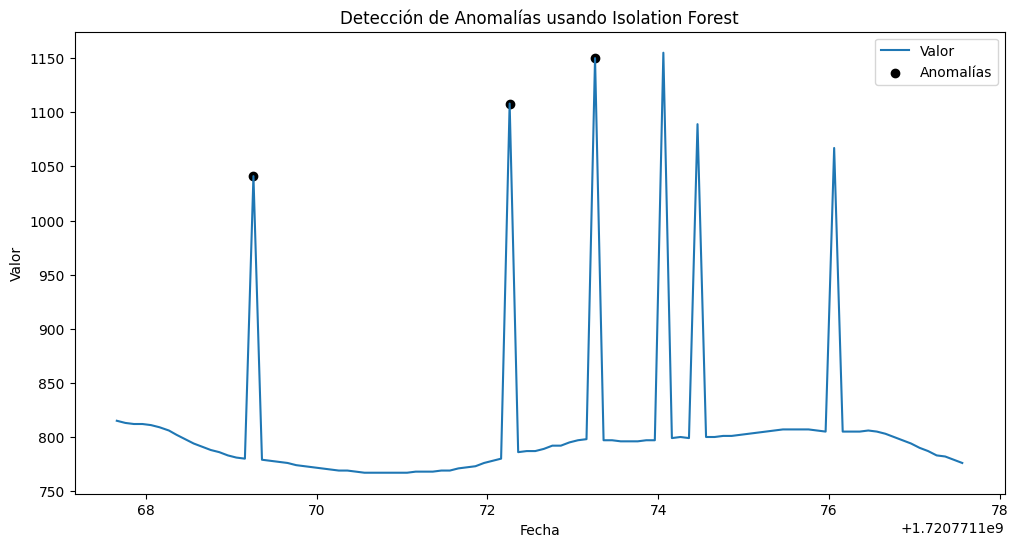

ROC: 0.75


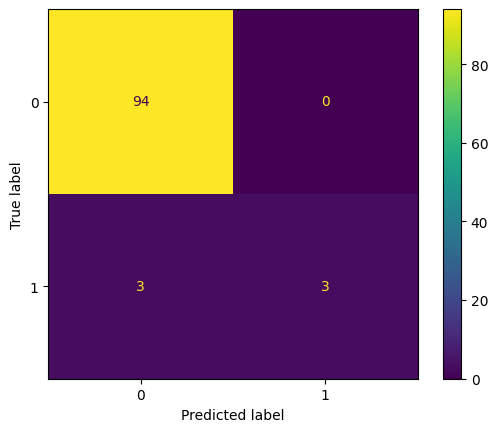

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

predictions_all = {}

idf = df
# Aplicar Isolation Forest
model = IsolationForest(contamination=0.03)  
idf['anomaly'] = model.fit_predict(idf)

# Visualizar las anomalías
anomalies = idf[idf['anomaly'] == -1]

predictions_all['IForest'] = idf['anomaly'].apply(lambda x: 0 if x == 1 else 1)
predictions_all['Real'] = idf['label']

plt.figure(figsize=(12, 6))
plt.plot(idf[['Timestamp (UNIX) ']], idf[['Speed (cm/s)']], label='Valor')
plt.scatter(anomalies[['Timestamp (UNIX) ']], anomalies[['Speed (cm/s)']], color='black', label='Anomalías')
# plt.scatter(df.loc[df['label'] == 1, 'Timestamp (UNIX) '], df.loc[df['label'] == 1, 'Speed (cm/s)'], color='red', label='Anomalías')
plt.title('Detección de Anomalías usando Isolation Forest')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

evaluate(idf['label'], predictions_all['IForest'])

# Autoencoder 1

2.9556848716735837
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
ROC: 0.7765957446808511


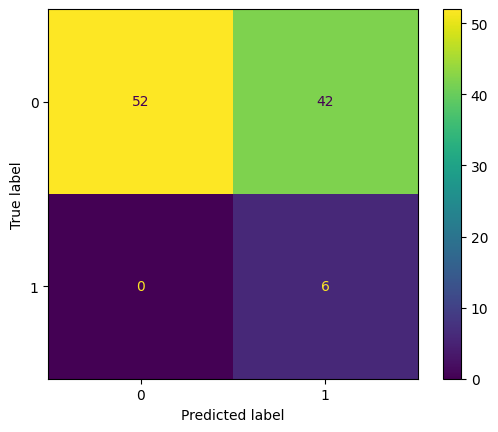

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from pyod.utils.data import evaluate_print

# Definir el modelo autoencoder multivariante
def crear_autoencoder_multivariante(dim_entrada):
    entrada = layers.Input(shape=(dim_entrada,))

    # Encoder with batch normalization
    codificador = layers.Dense(64, activation='relu')(entrada)
    codificador = layers.BatchNormalization()(codificador)
    codificador = layers.Dense(32, activation='relu')(codificador)
    codificador = layers.BatchNormalization()(codificador)

    # Decoder with batch normalization
    decodificador = layers.Dense(32, activation='relu')(codificador)
    decodificador = layers.BatchNormalization()(decodificador)
    decodificador = layers.Dense(dim_entrada, activation='linear')(decodificador)

    modelo = Model(entrada, decodificador)
    modelo.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    return modelo

data = df

columns = data.columns
serie_temporal_multivariable = data[columns]

# Normalizar la serie temporal multivariante
serie_normalizada = (serie_temporal_multivariable - serie_temporal_multivariable.mean()) / serie_temporal_multivariable.std()
# Crear el modelo autoencoder multivariante
dim_entrada = len(serie_normalizada.columns)
modelo_autoencoder_multivariante = crear_autoencoder_multivariante(dim_entrada)

# Entrenar el modelo autoencoder multivariante
historia = modelo_autoencoder_multivariante.fit(serie_normalizada.values, 
                                               serie_normalizada.values, 
                                               epochs=25, 
                                               batch_size=64,
                                               verbose = 0
                                               )

# Umbral de reconstrucción
umbral = np.percentile(historia.history['loss'], 99)
print(umbral)

# Predicción de la serie temporal normalizada
serie_reconstruida = modelo_autoencoder_multivariante.predict(serie_normalizada.values)

# Detección de anomalías
anomalias = serie_normalizada[np.linalg.norm(serie_normalizada.values - serie_reconstruida, axis=1) > umbral]

# Info
l1 = list(set(anomalias.index)) - anomalias.index[0]
l2 = list(set(data.loc[data['label'] == 1].index)) - anomalias.index[0]
labels_pred = np.zeros(len(data))
labels_real = np.zeros(len(data))
labels_pred[l1] = 1
labels_real[l2] = 1

evaluate(labels_real, labels_pred)

predictions_all['Autoencoder1'] = labels_pred

# Autoencoder 2

2.827660312652588
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
ROC: 0.7872340425531915


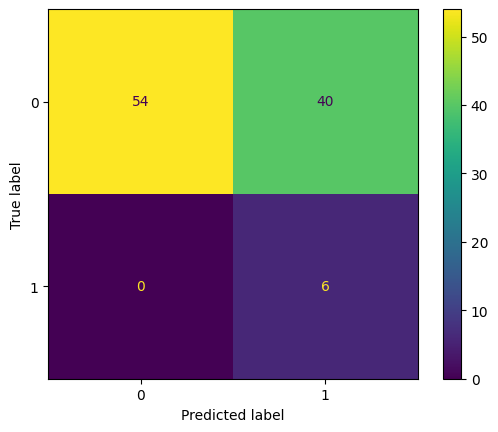

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from pyod.utils.data import evaluate_print

def crear_autoencoder_multivariante(dim_entrada):
    entrada = layers.Input(shape=(dim_entrada,))

    # Encoder with batch normalization and dropout
    codificador = layers.Dense(128, activation='relu')(entrada)
    codificador = layers.BatchNormalization()(codificador)
    codificador = layers.Dropout(0.2)(codificador)
    codificador = layers.Dense(64, activation='relu')(codificador)
    codificador = layers.BatchNormalization()(codificador)
    codificador = layers.Dense(32, activation='relu')(codificador)
    codificador = layers.BatchNormalization()(codificador)

    # Decoder with batch normalization and dropout
    decodificador = layers.Dense(32, activation='relu')(codificador)
    decodificador = layers.BatchNormalization()(decodificador)
    decodificador = layers.Dropout(0.2)(decodificador)
    decodificador = layers.Dense(64, activation='relu')(decodificador)
    decodificador = layers.BatchNormalization()(decodificador)
    decodificador = layers.Dense(128, activation='relu')(decodificador)
    decodificador = layers.BatchNormalization()(decodificador)
    decodificador = layers.Dense(dim_entrada, activation='linear')(decodificador)

    modelo = Model(entrada, decodificador)
    modelo.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    return modelo

data = df

columns = data.columns
serie_temporal_multivariable = data[columns]

# Normalizar la serie temporal multivariante
serie_normalizada = (serie_temporal_multivariable - serie_temporal_multivariable.mean()) / serie_temporal_multivariable.std()
# Definir el modelo autoencoder multivariante

# Crear el modelo autoencoder multivariante
dim_entrada = len(serie_normalizada.columns)
modelo_autoencoder_multivariante = crear_autoencoder_multivariante(dim_entrada)

# Entrenar el modelo autoencoder multivariante
historia = modelo_autoencoder_multivariante.fit(serie_normalizada.values, 
                                               serie_normalizada.values, 
                                               epochs=25, 
                                               batch_size=64,
                                               verbose = 0
                                               )

# Umbral de reconstrucción
umbral = np.percentile(historia.history['loss'], 99)
print(umbral)

# Predicción de la serie temporal normalizada
serie_reconstruida = modelo_autoencoder_multivariante.predict(serie_normalizada.values)

# Detección de anomalías
anomalias = serie_normalizada[np.linalg.norm(serie_normalizada.values - serie_reconstruida, axis=1) > umbral]

# Info
l1 = list(set(anomalias.index)) - anomalias.index[0]
l2 = list(set(data.loc[data['label'] == 1].index)) - anomalias.index[0]
labels_pred = np.zeros(len(data))
labels_real = np.zeros(len(data))
labels_pred[l1] = 1
labels_real[l2] = 1

evaluate(labels_real, labels_pred)

predictions_all['Autoencoder2'] = labels_pred

# Vote

ROC: 0.7978723404255319


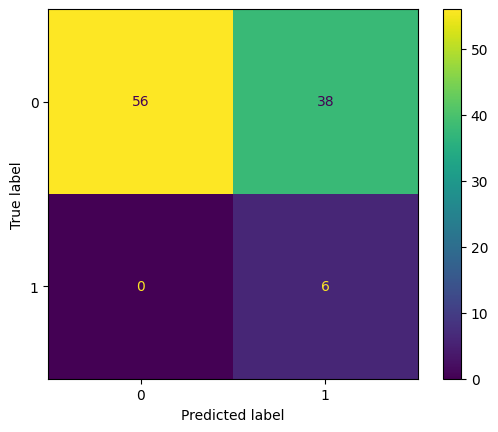

In [32]:
def majority_vote(predictions):
    arrays = []
    for p in predictions:
        if p != 'Real':
            arrays.append(predictions[p])
    # Stack the arrays along a new dimension
    stacked_arrays = np.stack(arrays, axis=0)
    
    # Calculate the sum along the new dimension
    sum_arrays = np.sum(stacked_arrays, axis=0)
    
    # Determine the majority vote (more than half of the arrays should have a 1)
    majority_threshold = len(arrays) / 2
    
    # If the sum is greater than the threshold, the majority is 1, otherwise 0
    majority_vote_result = (sum_arrays > majority_threshold).astype(int)
    
    return majority_vote_result

vote = majority_vote(predictions_all)

evaluate(predictions_all['Real'], vote)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class SimpleCNN(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the size of the feature map after the convolutions and pooling
        def conv2d_size_out(size, kernel_size=3, stride=1, padding=0):
            return (size - kernel_size + 2 * padding) // stride + 1
        
        # After first conv and pool
        conv1_out_dim = conv2d_size_out(input_dim, kernel_size=3)
        pool1_out_dim = conv1_out_dim // 2
        # After second conv and pool
        conv2_out_dim = conv2d_size_out(pool1_out_dim, kernel_size=3)
        pool2_out_dim = conv2_out_dim // 2
        
        self.fc1 = nn.Linear(in_features=64 * pool2_out_dim * pool2_out_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution -> ReLU -> Max pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.fc2(x)  # Fully connected layer
        return x

# Example usage
# Set random seed for reproducibility
torch.manual_seed(0)

# Define input dimensions and number of classes
input_dim = 28  # e.g., for MNIST images which are 28x28
num_classes = 10

# Initialize the model with the specified input dimensions
model = SimpleCNN(input_dim=input_dim, num_classes=num_classes)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

print(f'Test accuracy: {correct / len(test_loader.dataset):.4f}')
